In [31]:
import pandas as pd
import numpy as np
import json
import matplotlib
import matplotlib.pyplot as plt

#load dataset
df = pd.read_csv('raw_data/tmdb_5000_credits.csv')
df.head() #view data

,movie_id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [102]:
score = np.zeros(len(df.index)) #initalize scores
castsize = np.zeros(len(df.index), dtype=int) #initialize case sizes
g =[0]*len(df.index) #initialize gender list for all movies
wanttoweight = True #do you want to weight lead roles?
for m in df.index: #loop over all movies
    m_all = True #debug boolean
    #extract movie
    cast = json.loads(df['cast'][m]) #extract cast from dataset
    castsize[m] = len(cast) #number of cast members
    gendernos = np.zeros(castsize[m])
    if castsize[m] == 0 or castsize[m] == []: #no cast listed
        score[m] = np.nan #nan for no cast
        m_all = False #debug boolean
    else:
        if wanttoweight:
            #asymmetrical sigmoidal curve fit from https://mycurvefit.com/
            weights = [ 0.00557557 + (1.002644 - 0.00557557)/(1 + (x/1.794024)**8.661941)**0.5556762
               for x in np.linspace(1,10,20)] #weight lead roles more (up to 20 roles)
        else:
            weights = np.ones(20)
        if castsize[m] > 20: #more than 20 memebrs in cast
            ind = range(0,20)
        else: #less than 20 members in cast
            ind = range(0,castsize[m])
        for c in ind: #loop over all cast members
            gendernos[c] = cast[c]['gender']
            if cast[c]['gender'] == 1: #female
                score[m] = score[m] + weights[c] #female cast members boost score
                m_all = False #debug boolean
            elif cast[c]['gender'] != 2: #not female nor male gender number
                weights[c] = 0; #discount entry
        score[m] = score[m]/sum(weights[:c+1]) #take the weighted average of the score
        g[m] = gendernos #store gender numbers into gender list
        if score[m] == np.inf:
            score[m] = np.nan
            m_all = False #debug boolean
    #DEBUGGING ONLY
    #if m_all:
         #score[m] = -1
#put scores into dataframe
df['gender diversity score'] = score
df.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in double_scalars


,movie_id,title,cast,crew,gender diversity score
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de...",0.532074
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de...",0.187119
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de...",0.233717
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de...",0.101576
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de...",0.495550


In [104]:
#extract nan values to find real score
score_real = score[np.argwhere(~np.isnan(score))]
len(score_real) #check size of real values

4717

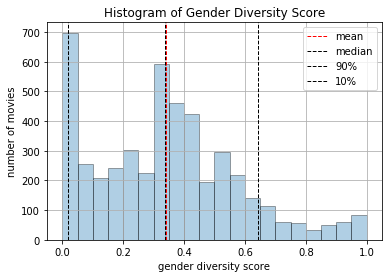

In [105]:
#plot results of all movies
n_bins = 20
fig, ax = plt.subplots()
n, bins, patches = plt.hist(score_real, bins=n_bins, alpha=0.35, edgecolor='k')
ax.set(xlabel='gender diversity score', ylabel='number of movies',
       title='Histogram of Gender Diversity Score')
ax.grid()
mean = plt.axvline(score_real.mean(), color='r', linestyle='dashed', linewidth=1)
median = plt.axvline(np.percentile(score_real,50), color='k', linestyle='dashed', linewidth=1)
#plt.axvline(np.percentile(score_real,25), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(np.percentile(score_real,75), color='r', linestyle='dashed', linewidth=1)
ninety = plt.axvline(np.percentile(score_real,90), color='k', linestyle='dashed', linewidth=1)
ten = plt.axvline(np.percentile(score_real,10), color='k', linestyle='dashed', linewidth=1)
ax.legend((mean, median, ninety, ten), ('mean','median','90%','10%'))


In [139]:
#create subset
df_subset = pd.DataFrame(columns=list(df)) #initialize
df_real = df.dropna() #get rid of nans
strata = 10 #how many data strata do we want?
subsetno = 100 #how large do we want the subset to be
edges = np.linspace(0,1,strata+1) #edges of data strata
for i in range(0,strata):
    df_temp = df_real[(df_real['gender diversity score'] > edges[i]) &
                      (df_real['gender diversity score'] < edges[i+1])]
    temp_ind = np.round(np.linspace(0,len(df_temp)-1,subsetno/strata))
    df_subset = pd.concat([df_subset, 
                         df_temp.sort_values(by=['gender diversity score']).iloc[temp_ind,:].reset_index(drop=True)], 
                         ignore_index=True)
df_subset
#json.loads(df_subset['cast'][4]) #if you want to query a specific movie

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


,movie_id,title,cast,crew,gender diversity score
0,387,Das Boot,"[{""cast_id"": 1, ""character"": ""Kapit\u00e4n-Leu...","[{""credit_id"": ""52fe423dc3a36847f800eb0d"", ""de...",0.001949
1,11176,The Muppet Movie,"[{""cast_id"": 1, ""character"": ""Kermit the Frog ...","[{""credit_id"": ""52fe44089251416c75026ab7"", ""de...",0.006318
2,13807,Exiled,"[{""cast_id"": 1, ""character"": ""Blaze"", ""credit_...","[{""credit_id"": ""52fe45a39251416c7505d563"", ""de...",0.011778
3,22649,A Farewell to Arms,"[{""cast_id"": 1, ""character"": ""Catherine Barkle...","[{""credit_id"": ""56d73d3e9251414291002436"", ""de...",0.019327
4,468,My Own Private Idaho,"[{""cast_id"": 3, ""character"": ""Mike Waters"", ""c...","[{""credit_id"": ""52fe4247c3a36847f8011d0b"", ""de...",0.029018
5,84197,Filly Brown,"[{""cast_id"": 1002, ""character"": ""Linda"", ""cred...","[{""credit_id"": ""52fe48e09251416c9109b2fd"", ""de...",0.040096
6,2770,American Pie 2,"[{""cast_id"": 1, ""character"": ""Jim Levenstein"",...","[{""credit_id"": ""5564ee039251416f25000f6d"", ""de...",0.052440
7,72431,Red Tails,"[{""cast_id"": 2, ""character"": ""Colonel William ...","[{""credit_id"": ""53677d8c0e0a2647c4005769"", ""de...",0.078485
8,66195,The Perfect Host,"[{""cast_id"": 1, ""character"": ""Warwick Wilson"",...","[{""credit_id"": ""52fe4730c3a368484e0b9927"", ""de...",0.086259
9,10673,Wall Street,"[{""cast_id"": 8, ""character"": ""Bud Fox"", ""credi...","[{""credit_id"": ""52fe43a09251416c75017bd9"", ""de...",0.099810


In [140]:
len(df_subset)

100

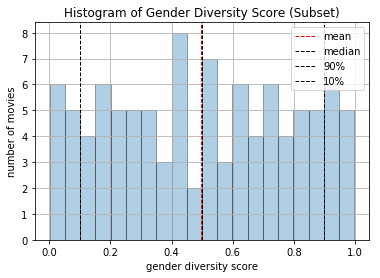

In [146]:
#plot subset results
subset_scores = df_subset['gender diversity score'][:]
n_bins = 20
fig, ax = plt.subplots()
n, bins, patches = plt.hist(subset_scores, bins=n_bins, alpha=0.35, edgecolor='k')
ax.set(xlabel='gender diversity score', ylabel='number of movies',
       title='Histogram of Gender Diversity Score (Subset)')
ax.grid()
mean = plt.axvline(subset_scores.mean(), color='r', linestyle='dashed', linewidth=1)
median = plt.axvline(np.percentile(subset_scores,50), color='k', linestyle='dashed', linewidth=1)
#plt.axvline(np.percentile(subset_scores,25), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(np.percentile(subset_scores,75), color='r', linestyle='dashed', linewidth=1)
ninety = plt.axvline(np.percentile(subset_scores,90), color='k', linestyle='dashed', linewidth=1)
ten = plt.axvline(np.percentile(subset_scores,10), color='k', linestyle='dashed', linewidth=1)
ax.legend((mean, median, ninety, ten), ('mean','median','90%','10%'))

In [ ]:
#plot cast distribution
castsizes_real = df_subset['gender diversity score'][:]
n_bins = 20
fig, ax = plt.subplots()
n, bins, patches = plt.hist(subset_scores, bins=n_bins, alpha=0.35, edgecolor='k')
ax.set(xlabel='gender diversity score', ylabel='number of movies',
       title='Histogram of Gender Diversity Score (Subset)')
ax.grid()
mean = plt.axvline(subset_scores.mean(), color='r', linestyle='dashed', linewidth=1)
median = plt.axvline(np.percentile(subset_scores,50), color='k', linestyle='dashed', linewidth=1)
#plt.axvline(np.percentile(subset_scores,25), color='r', linestyle='dashed', linewidth=1)
#plt.axvline(np.percentile(subset_scores,75), color='r', linestyle='dashed', linewidth=1)
ninety = plt.axvline(np.percentile(subset_scores,90), color='k', linestyle='dashed', linewidth=1)
ten = plt.axvline(np.percentile(subset_scores,10), color='k', linestyle='dashed', linewidth=1)
ax.legend((mean, median, ninety, ten), ('mean','median','90%','10%'))

In [147]:
#save subset
df.to_csv('imdb_subset_100_10strats')

AttributeError: 'DataFrame' object has no attribute 'close'

In [ ]:
'''
Next steps:
1. create histogram of cast size
2. make scores a 2D array or data frame that includes movie ID
3. extract 100 evenly distributed (in terms of score) movie IDs
4. load subsampled imdb data to repo
'''